In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
from utils.path import WilcardPath
from utils.dataloading import read_parquet_summary_file, format_summary_df
import os
from pathlib import Path
import sys
from utils.enums import AlignerEnum
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.manifold
import numpy as np

In [3]:
DATA_DIR = WilcardPath("/hits/fast/cme/bodynems/data/")

BENCHMARKS = ["balibase3/RV11", "balibase3/RV12"]
INPUT_DIR = DATA_DIR / "input" / "{benchmark}"
OUTPUT_DIR = DATA_DIR / "output" / "{benchmark}"

DATASET_DIR = OUTPUT_DIR / "{dataset}"

FEAT_FILE_PATH = DATASET_DIR / "{file_name}"
TOOL_DIR = DATASET_DIR / "{tool}"

DATASET_FEAT_FILE = "dataset_features.parquet"
ENSEMBLE_FEAT_FILE = "ensemble_features.parquet"
TOOLS = [aligner for aligner in AlignerEnum]

In [196]:
dataset_dfs = []
ensemble_dfs = []
for benchmark in BENCHMARKS:
    for dataset in OUTPUT_DIR.format(benchmark=benchmark).listdir(dirs_only=True):
        wildcards = dict(benchmark=benchmark, dataset=dataset)

        wildcards["file_name"] = DATASET_FEAT_FILE
        temp_df = read_parquet_summary_file(FEAT_FILE_PATH, **wildcards)
        dataset_dfs.append(temp_df)

        wildcards["file_name"] = ENSEMBLE_FEAT_FILE
        temp_df = read_parquet_summary_file(FEAT_FILE_PATH, **wildcards)
        ensemble_dfs.append(temp_df)

dataset_df = pd.concat(dataset_dfs, axis=0, ignore_index=True)
ensemble_df = pd.concat(ensemble_dfs, axis=0, ignore_index=True)

Index(['avg_perc_hash_hamming_16bit', 'avg_perc_hash_hamming_256bit', 'lc',
       'cc', 'dispersion', 'avg_min_inflation', 'avg_max_inflation',
       'min_normalized_sp_score', 'max_normalized_sp_score',
       'mean_normalized_sp_score', 'std_normalized_sp_score', 'tool',
       'dataset', 'path', 'benchmark'],
      dtype='object')


Text(0.5, 1.0, 'Correlation of Ensemble Features')

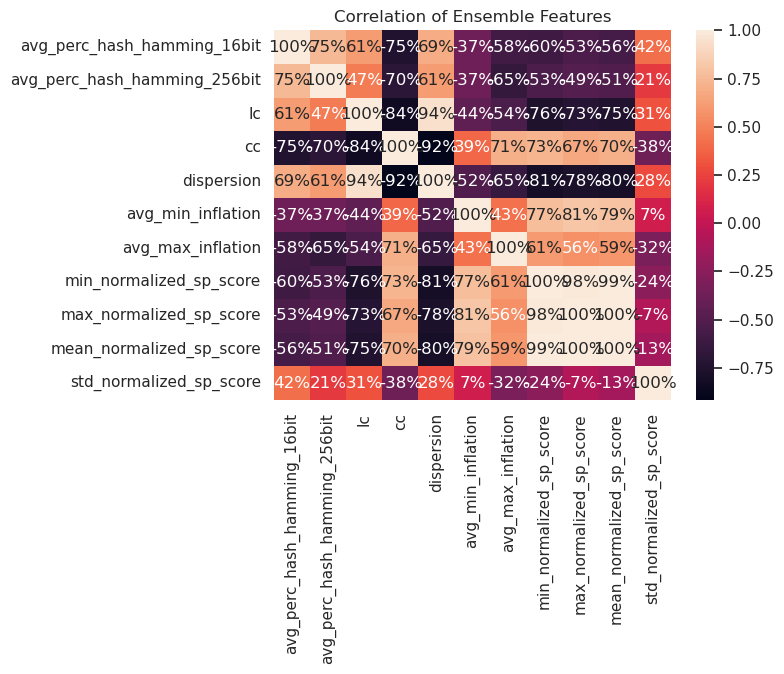

In [381]:
plt.figure()
# Filter for rows where the features were computed on the full ensemble
full_ensemble_mask = ensemble_df.tool == "all"
sns.heatmap(
    ensemble_df[full_ensemble_mask].select_dtypes(exclude="object").corr(),
    annot=True,
    fmt=".0%",
)
plt.title("Correlation of Ensemble Features")

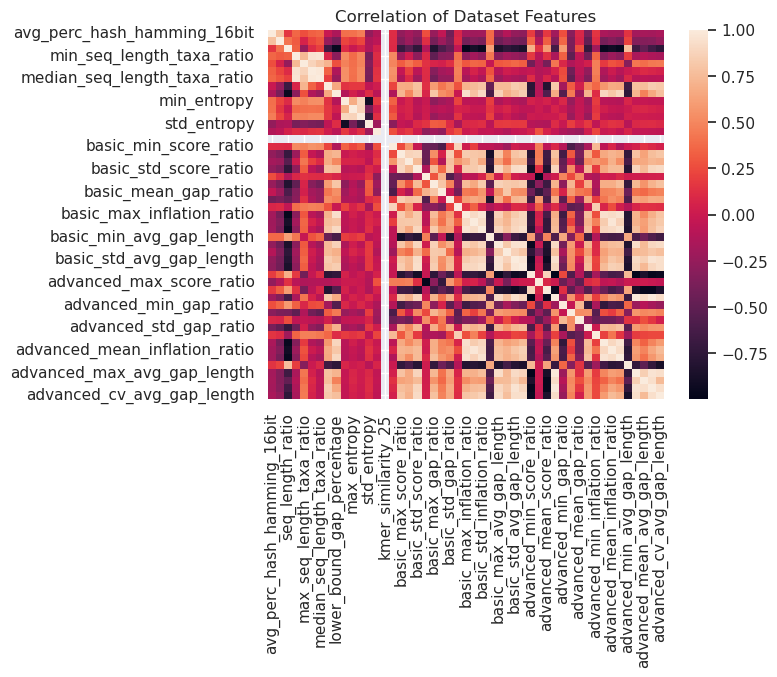

In [198]:
# sns.heatmap(feat_df.select_dtypes(exclude="object").corr(), annot=True, fmt=".2%")
plt.figure()
sns.heatmap(dataset_df.select_dtypes(exclude="object").corr())
plt.title("Correlation of Dataset Features")
plt.show()

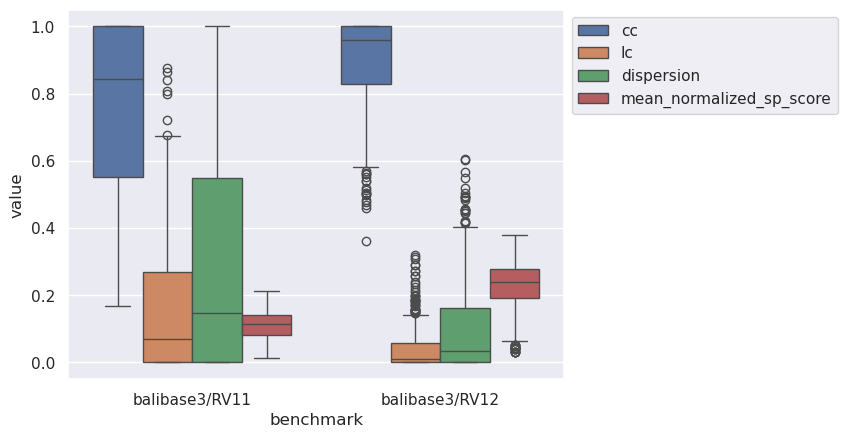

In [233]:
# Plot some ensemble statistics as boxplots
sns.set_theme(style="darkgrid")
plot_df = ensemble_df[
    ["cc", "lc", "dispersion", "mean_normalized_sp_score", "tool", "benchmark"]
]
plot_df = plot_df.melt(
    id_vars=["tool", "benchmark"],
    value_vars=["cc", "lc", "dispersion", "mean_normalized_sp_score"],
)
sns.boxplot(plot_df, x="benchmark", y="value", hue="variable")
plt.legend(bbox_to_anchor=(1.0, 1.0))

In [234]:
# Pivot the ensemble features to individual columns for each tool-metric combination
pivot_ensemble_df = format_summary_df(ensemble_df)
print(pivot_ensemble_df.shape)
print(
    f"{pivot_ensemble_df.shape[0]} MSAs, {
        pivot_ensemble_df.shape[1]} ensemble features"
)

(162, 56)
162 MSAs, 56 ensemble features


In [374]:
from features.feature import FEATURES
from utils.enums import FeatureTypeEnum
import re

label_df = pivot_ensemble_df.select_dtypes(exclude="object")

# Remote "std" features because their impact is not clear
non_std_columns = label_df.columns[
    [re.search("std_", col) is None for col in label_df.columns]
]
label_df = label_df[non_std_columns]
# Only use "all" features (since they incorporate all ensembles)
label_df = label_df[label_df.columns[label_df.columns.str.startswith("all.")]]

print(f"(n, m) = {label_df.shape}")

feat_sign_map = dict(zip(label_df.columns, np.ones(len(label_df))))
signs = {FeatureTypeEnum.MIN: 1, FeatureTypeEnum.MAX: -1}
for feat in FEATURES.values():
    feat_cols = feat.extract_cols_from_df(label_df)
    for feat_col in feat_cols:
        feat_sign_map[feat_col] = signs[feat.feature_type]

# Map to new signs for positive correlations of min and max features
label_df = label_df.multiply(feat_sign_map, axis=1)
# Standardize features
# label_df = (label_df - label_df.mean(0)) / label_df.std(0)
print(f"smallest correlation coefficient: {
      label_df.corr().min(None).round(4)}")

(n, m) = (162, 10)
smallest correlation coefficient: 0.3724


In [377]:
label_df.head()
feat_sign_map

{'all.avg_max_inflation': -1,
 'all.avg_min_inflation': -1,
 'all.avg_perc_hash_hamming_16bit': 1,
 'all.avg_perc_hash_hamming_256bit': 1,
 'all.cc': -1,
 'all.dispersion': 1,
 'all.lc': 1,
 'all.max_normalized_sp_score': -1,
 'all.mean_normalized_sp_score': -1,
 'all.min_normalized_sp_score': -1}

<Axes: ylabel='Count'>

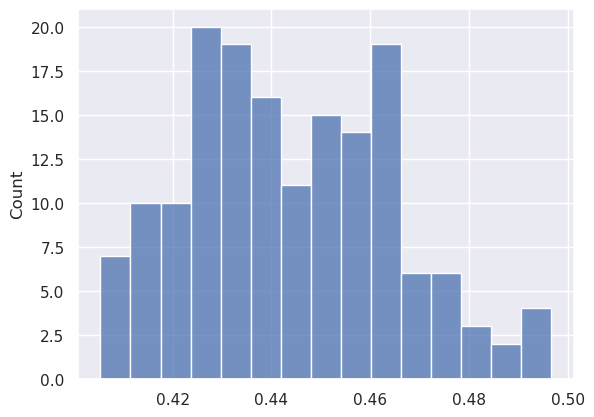

In [372]:
def sigmoid(x):
    return 1 / (1 + np.exp(1 * (-x.mean(1))))


def log_exp(x):
    return np.log(np.exp(x).mean(1))


def exp_log(x):
    return 1 - np.exp(1 * (-np.log(1 + x.mean(1))))


labels = sigmoid(label_df)
# labels = log_exp(label_df)
sns.histplot(labels, bins=15)

In [373]:
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection
import sklearn.svm

np.random.seed(0)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    dataset_df.select_dtypes(exclude="object"), labels, test_size=0.3
)
# X_test = X_train
# y_test = y_train
reg = sklearn.svm.SVR()
reg.fit(X_train, y_train)
pred = reg.predict(X_test)
print("RMSE: ", sklearn.metrics.root_mean_squared_error(y_test, pred))
print("MAPE: ", sklearn.metrics.mean_absolute_percentage_error(y_test, pred))

RMSE:  0.021765697053442074
MAPE:  0.04119113788982798


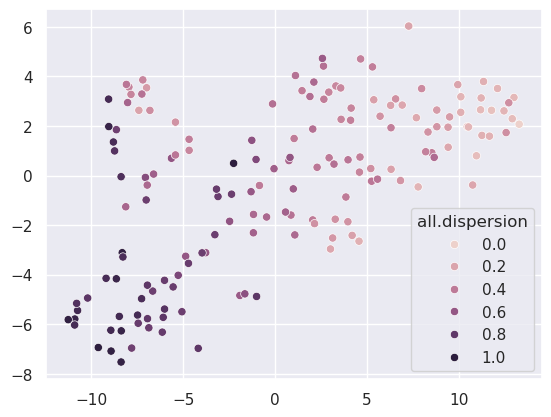

In [367]:
import sklearn.manifold

tsne = sklearn.manifold.TSNE()
label_df = label_df.dropna(axis=1)
embeddings_tsne = tsne.fit_transform(
    label_df.dropna(axis=1).drop("all.dispersion", axis=1)
)
sns.scatterplot(
    x=embeddings_tsne[:, 0],
    y=embeddings_tsne[:, 1],
    hue=label_df["all.dispersion"],
)
plt.show()